Fit Baker et al. data with linear model using ridge regression.

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.linear_model import Ridge
import sys

from aux import make_dsn_mat
from disp import set_plot
from record_2_lin_ln import smlt_linr

cc = np.concatenate

FPS = 30.03
DT = 1/FPS

DUR_H = 10
IDUR_H = int(round(DUR_H/DT))

NNRN = 224
ALPHA = 100  # ridge regression param

FSAVE = 'data/simple/neur/baker_linr.npy'

In [2]:
# load data
DF_S = pd.read_csv('data/simple/neur/baker_resampled_s.csv')
DF_P = pd.read_csv('data/simple/neur/baker_resampled_p.csv')

I_S = np.array(DF_S['S'])
I_P = np.array(DF_P['P'])

R_SS = np.array(DF_S[[f'R_{cnrn}' for cnrn in range(NNRN)]])
R_PS = np.array(DF_P[[f'R_{cnrn}' for cnrn in range(NNRN)]])

Fit linear filters

In [3]:
# loop over expt_ids
h_ss = np.nan*np.zeros((IDUR_H, NNRN))
h_ps = np.nan*np.zeros((IDUR_H, NNRN))

r_fit_ss = np.nan*R_SS
r_fit_ps = np.nan*R_PS

for expt_id in range(NNRN):
    sys.stdout.write('.')
    r_s = R_SS[:, expt_id]
    r_p = R_PS[:, expt_id]
    
    mvalid_s = ~np.isnan(r_s)
    mvalid_p = ~np.isnan(r_p)
    
    # fit model
    # build stim design matrix
    stim_mat_s = make_dsn_mat(I_S, IDUR_H)
    stim_mat_p = make_dsn_mat(I_P, IDUR_H)

    # get filter
    rgr_s = Ridge(alpha=ALPHA, fit_intercept=False).fit(stim_mat_s[mvalid_s, :], r_s[mvalid_s]/DT) 
    h_s = rgr_s.coef_[::-1]
    
    rgr_p = Ridge(alpha=ALPHA, fit_intercept=False).fit(stim_mat_p[mvalid_p, :], r_p[mvalid_p]/DT) 
    h_p = rgr_p.coef_[::-1]

    h_ss[:, expt_id] = h_s
    h_ps[:, expt_id] = h_p
    
    r_fit_ss[mvalid_s, expt_id] = rgr_s.predict(stim_mat_s[mvalid_s, :])*DT
    r_fit_ps[mvalid_p, expt_id] = rgr_p.predict(stim_mat_p[mvalid_p, :])*DT
    
params = {'EXPT_ID': range(NNRN), 'H_SS': h_ss, 'H_PS': h_ps}
np.save(FSAVE, np.array([params]))

................................................................................................................................................................................................................................

# Examine fits

In [4]:
params = np.load(FSAVE, allow_pickle=True)[0]
r_smln_ss = smlt_linr(I_S, 0*I_P, params, DT)
r_smln_ps = smlt_linr(0*I_S, I_P, params, DT)

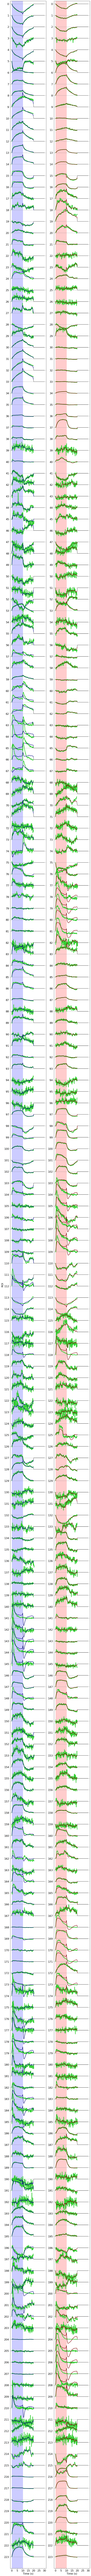

In [5]:
nplot = NNRN
t = np.arange(len(R_SS))*DT

fig, axs = plt.subplots(1, 2, figsize=(8, nplot), tight_layout=True)
y_ticks = []

for cexpt in range(nplot):
    y_tick = -4*cexpt
    
    ## sine response
    axs[0].axhline(y_tick, lw=1, ls='--', c='gray')
    axs[0].plot(t, R_SS[:, cexpt] + y_tick, c='limegreen', lw=3)  # true
    axs[0].plot(t, r_fit_ss[:, cexpt] + y_tick, c='b', lw=2)  # fit
    axs[0].plot(t, r_smln_ss[:, cexpt] + y_tick, c='k', lw=1)  # simulated 
    
    ## pulse response
    axs[1].axhline(y_tick, lw=1, ls='--', c='gray')
    axs[1].plot(t, R_PS[:, cexpt] + y_tick, c='limegreen', lw=3)
    axs[1].plot(t, r_fit_ps[:, cexpt] + y_tick, c='r', lw=2)  # fit
    axs[1].plot(t, r_smln_ps[:, cexpt] + y_tick, c='k', lw=1)  # simulated
    
    y_ticks.append(y_tick)
    
axs[0].axvspan(0, 10, color='b', alpha=.2)
axs[1].axvspan(0, 10, color='r', alpha=.2)

axs[0].set_ylabel('ROI')

for ax in axs:
    set_plot(ax, y_lim=(-4*NNRN, 1), y_ticks=y_ticks, y_tick_labels=range(NNRN), x_label='Time (s)', font_size=16)